# Optical Flow with Convolution Neural Networks

The paper we based this project on is a method of computing optical flow with a convolutional neural network. The network is trained with a flow vector generated by the Lucas-Kanade method, then recomputed via the neural net to test the accuracy of the neural net's operation.

We decided to make some improvements to the Optical Flow calculation, namely relying on eigenvalues for the vector computation and using the Pyramidal approach to more adequately handle high-resolution files with extremely large differentials between them. 

The paper's version of optical flow produces a vector <-x, +x, -y, +y, -z, +z>.
Our result vector needs to change in track_object(frame1, frame2, x, y, w, h, steps) - currently the displacement should be `[x,y]`, so we'll just need to do some conditional wizardry and expand it out.

*NOTE:* Prior to running any of this, a virtual environment is needed. Once in the venv, run `pip install -r requirements.txt` to prepare all of the required libraries.

In [1]:
import numpy as np
flow = np.array([-2,3])
final_flow = np.array([0, 0, 0, 0, 0, 0])

if flow[0] < 0:
    final_flow[0] = abs(flow[0])
elif flow[0] > 0:
    final_flow[1] = abs(flow[0])

if flow[1] < 0:
    final_flow[2] = abs(flow[1])
elif flow[1] > 0:
    final_flow[3] = abs(flow[1])
final_flow

array([2, 0, 0, 3, 0, 0])

The videos used are all releaseed under the Creative Commons Attribution 3.0 license.
We can generate the list of all files in the training directory (in this case, a scene from "Big Buck Bunny") as follows:

In [2]:
import os
file_list = os.listdir("bunny")
file_list

['frame-1313.png',
 'frame-1153.png',
 'frame-1307.png',
 'frame-1309.png',
 'frame-1286.png',
 'frame-1222.png',
 'frame-1208.png',
 'frame-1305.png',
 'frame-1342.png',
 'frame-1239.png',
 'frame-1232.png',
 'frame-1276.png',
 'frame-1317.png',
 'frame-1198.png',
 'frame-1201.png',
 'frame-1228.png',
 'frame-1163.png',
 'frame-1146.png',
 'frame-1179.png',
 'frame-1194.png',
 'frame-1328.png',
 'frame-1339.png',
 'frame-1192.png',
 'frame-1264.png',
 'frame-1246.png',
 'frame-1177.png',
 'frame-1161.png',
 'frame-1266.png',
 'frame-1235.png',
 'frame-1269.png',
 'frame-1262.png',
 'frame-1213.png',
 'frame-1271.png',
 'frame-1302.png',
 'frame-1311.png',
 'frame-1186.png',
 'frame-1237.png',
 'frame-1209.png',
 'frame-1185.png',
 'frame-1304.png',
 'frame-1261.png',
 'frame-1293.png',
 'frame-1221.png',
 'frame-1225.png',
 'frame-1160.png',
 'frame-1214.png',
 'frame-1180.png',
 'frame-1189.png',
 'frame-1215.png',
 'frame-1164.png',
 'frame-1203.png',
 'frame-1204.png',
 'frame-1257

We'll need to add the directory name to the beginning of each file:

In [3]:
for x in range(len(file_list)):
    file_list[x] = 'bunny/' + file_list[x]
file_list.sort()
file_list

['bunny/frame-1146.png',
 'bunny/frame-1147.png',
 'bunny/frame-1148.png',
 'bunny/frame-1149.png',
 'bunny/frame-1150.png',
 'bunny/frame-1151.png',
 'bunny/frame-1152.png',
 'bunny/frame-1153.png',
 'bunny/frame-1154.png',
 'bunny/frame-1155.png',
 'bunny/frame-1156.png',
 'bunny/frame-1157.png',
 'bunny/frame-1158.png',
 'bunny/frame-1159.png',
 'bunny/frame-1160.png',
 'bunny/frame-1161.png',
 'bunny/frame-1162.png',
 'bunny/frame-1163.png',
 'bunny/frame-1164.png',
 'bunny/frame-1165.png',
 'bunny/frame-1166.png',
 'bunny/frame-1167.png',
 'bunny/frame-1168.png',
 'bunny/frame-1169.png',
 'bunny/frame-1170.png',
 'bunny/frame-1171.png',
 'bunny/frame-1172.png',
 'bunny/frame-1173.png',
 'bunny/frame-1174.png',
 'bunny/frame-1175.png',
 'bunny/frame-1176.png',
 'bunny/frame-1177.png',
 'bunny/frame-1178.png',
 'bunny/frame-1179.png',
 'bunny/frame-1180.png',
 'bunny/frame-1181.png',
 'bunny/frame-1182.png',
 'bunny/frame-1183.png',
 'bunny/frame-1184.png',
 'bunny/frame-1185.png',


Just for reference, let's take a look at the scene we're talking about.

First off, let's look at a couple of optical flow examples.

In [4]:
from optical_flow import run_lk

flow_vector = run_lk(file_list[0], file_list[1], 124, 158, 254, 233, steps=5)
flow_vector

[0, 0.14430177, 0, 0.03125444, 0, 0]

Just to show what this looks like, we'll define a function visualize identical to the one we used in homework 3 and run it on the initial flow vector.

In [5]:
import imageio

def visualize(first, firstBB, second, secondBB):
    import matplotlib
    import matplotlib.pyplot as plt

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    ax1.imshow(first)
    ax1.set_title('First Frame')
    rect = matplotlib.patches.Rectangle(
        (firstBB[0], firstBB[1]), firstBB[2], firstBB[3], edgecolor='r', facecolor="none")
    ax1.add_patch(rect)

    ax2.imshow(second)
    ax2.set_title('Second Frame')
    rect = matplotlib.patches.Rectangle(
        (secondBB[0], secondBB[1]), secondBB[2], secondBB[3], edgecolor='r', facecolor="none")
    ax2.add_patch(rect)

    plt.show()

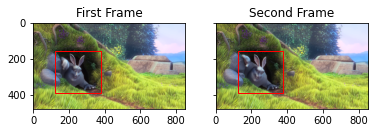

In [6]:
new_box = [124 - flow_vector[0] + flow_vector[1], 158 - flow_vector[2] + flow_vector[3], 254, 233]
visualize(imageio.imread(file_list[1])[:, :, :3].astype(np.float32) / 255.0,
          [124, 158, 254, 233],
          imageio.imread(file_list[2])[:, :, :3].astype(np.float32) / 255.0,
          new_box)

We can track the same bounding box's movement in the next frame as well:

In [7]:
flow_vector = run_lk(file_list[1], file_list[2], 124-flow_vector[0]+flow_vector[1],
                                                 158-flow_vector[2]+flow_vector[3],
                                                 254, 233, steps=5)
flow_vector

[0, 0.11882825, 0, 0.48146176, 0, 0]

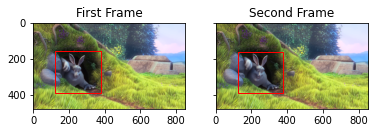

In [8]:
next_box = [new_box[0] - flow_vector[0] + flow_vector[1], new_box[1] - flow_vector[2] + flow_vector[3], new_box[2], new_box[3]]
visualize(imageio.imread(file_list[0])[:, :, :3].astype(np.float32) / 255.0,
          new_box,
          imageio.imread(file_list[1])[:, :, :3].astype(np.float32) / 255.0,
          next_box)

Preparing the dataset will use the `prepare_dataset` function in the `optical_flow.py` file. The signature for this function is:
`prepare_dataset(files_list, result_file, x, y, w, h, steps=5)`
The bounding box should be determined for the scene, and consists of the x,y,w,h parameters.

In [9]:
from optical_flow import prepare_dataset
prepare_dataset(file_list, "train-data.csv", 124, 158, 254, 233, steps=5)

To train and evaluate the neural net, we'll use the Lkvf file.

In [10]:
from Lkvf import train
history = train()

067 - accuracy: 0.9966
Epoch 312/500
149/149 [==============================] - 0s 382us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 313/500
149/149 [==============================] - 0s 377us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 314/500
149/149 [==============================] - 0s 438us/step - loss: 0.0046 - accuracy: 0.9978
Epoch 315/500
149/149 [==============================] - 0s 421us/step - loss: 0.0073 - accuracy: 0.9978
Epoch 316/500
149/149 [==============================] - 0s 386us/step - loss: 0.0095 - accuracy: 0.9978
Epoch 317/500
149/149 [==============================] - 0s 398us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 318/500
149/149 [==============================] - 0s 481us/step - loss: 0.0091 - accuracy: 0.9966
Epoch 319/500
149/149 [==============================] - 0s 439us/step - loss: 0.0073 - accuracy: 0.9989
Epoch 320/500
149/149 [==============================] - 0s 384us/step - loss: 0.0051 - accuracy: 0.9989
Epoch 321/500
149/149 [=========

Once we're trained up, we can check some visualizing through matplotlib to get an idea of our accuracy. This can be seen to approach very close to 100% accuracy, and finishes the training and evaluating loop with less than 1% loss. Compare that with the graphs from the original paper (showing here), and we can see that the mini-batch gradient descent method we implemented has a much greater chance of correctly evaluating the flow vector.

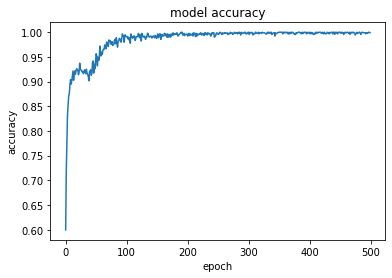

In [11]:
from matplotlib import pyplot as plt


plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

And the loss factor in the model:

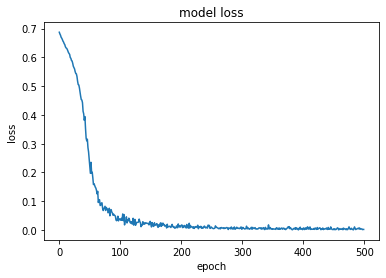

In [12]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Let's look at the results of the LK prediction model.

In [13]:
from RunLKNN import LK, loadNN

model = loadNN('model.yaml', 'model.h5')

first_frame = imageio.imread(file_list[0])[:, :, :3].astype(np.float32) / 255.0
second_frame = imageio.imread(file_list[1])[:, :, :3].astype(np.float32) / 255.0

result = LK(first_frame, second_frame, 124, 158, 254, 233, model)
result

Loaded model from disk


[9.2894766e-08, 8.835236e-09, 4.2597703e-09]

And visualize the result:

bunny/frame-1146.png
bunny/frame-1147.png


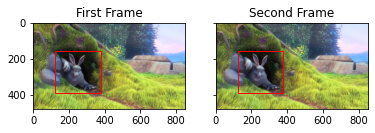

In [15]:
visualize(imageio.imread(file_list[0])[:, :, :3].astype(np.float32) / 255.0,
          [124, 158, 254, 233],
          imageio.imread(file_list[1])[:, :, :3].astype(np.float32) / 255.0,
          [124+result[0], 158+result[1], 254, 233])